# Python: Basic processing of hyperspectral imagery from AVIRIS-NG collected during ABoVE airborne campaigns

Hyperspectral imagery from the Airborne Visible InfraRed Imaging Spectrometer-Next Generation (AVIRIS-NG) was collected as part of the Arctic-Boreal Vulnerability Experiment (ABoVE) in 2017 and 2018 and archived at the ORNL DAAC. File sizes can be prohibitively large due to the large number of raster bands. This tutorial will show users some ways to work with the data in Python.

## Dataset

### ABoVE: Hyperspectral Imagery from AVIRIS-NG for Alaskan and Canadian Arctic   
[https://doi.org/10.3334/ORNLDAAC/1569](https://doi.org/10.3334/ORNLDAAC/1569)  

**Abstract**     

This dataset provides level 1 radiance and level 2 surface reflectance measured by the Airborne Visible/Infrared Imaging Spectrometer-Next Generation (AVIRIS-NG) instrument during flights over the Arctic-Boreal Vulnerability Experiment (ABoVE) domain between June and August 2017. AVIRIS-NG measures reflected radiance at 5-nanometer (nm) intervals in the visible to shortwave infrared spectral range between 380 and 2510 nm. Measurements are radiometrically and geometrically calibrated and provided at approximately 5-meter spatial resolution. The data include 422 flight lines covering areas of interest to the ABoVE campaign over much of Alaska and western Canada. These data will allow researchers to characterize ecosystem structure and function near the height of the growing season. This dataset represents one part of a multisensor airborne sampling campaign conducted by eleven different aircraft teams for ABoVE.


**Citation**     
```
Miller, C.E., R.O. Green, D.R. Thompson, A.K. Thorpe, M. Eastwood, I.B. Mccubbin, W. Olson-duvall, M. Bernas, C.M. Sarture, S. Nolte, L.M. Rios, M.A. Hernandez, B.D. Bue, and S.R. Lundeen. 2018. ABoVE: Hyperspectral Imagery from AVIRIS-NG for Alaskan and Canadian Arctic, 2017. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/1569
```

Please see the **User Guide** for a comprehensive description of this dataset:              
https://daac.ornl.gov/ABOVE/guides/ABoVE_Airborne_AVIRIS_NG.html

## Prerequisites           

### Python 3.x
modules: tarfile, json, math, numpy, pandas, gdal/ogr, affine, matplotlib

### Imagery
Each flight line in the dataset has two corresponding granules, each in a zipped tarfile:            
* level 1 radiance, e.g. ang20180814t224053.tar.gz            
* level 2 reflectance, e.g. ang20180814t224053rfl.tar.gz     

This tutorial works with the L2 reflectance data for a flight on August 14, 2018. Download the zi at the following link:      
**[https://daac.ornl.gov/daacdata/above/ABoVE_Airborne_AVIRIS_NG/data/ang20180814t224053rfl.tar.gz](https://daac.ornl.gov/daacdata/above/ABoVE_Airborne_AVIRIS_NG/data/ang20180814t224053rfl.tar.gz)** 

Each reflectance tarfile contains two pairs of ENVI (Harris Geospatial) binary image files (no extension) and accompanying header files (.hdr):

**Orthocorrected and atmospherically corrected reflectance data**               
*angYYYYMMDDtHHNNSS_corr_VVV_img (& .hdr*)

Atmospherically corrected water-leaving reflectance (Gao et al. 1993; Thompson et al. 2015); 425 bands at 5-nm intervals in the visible to shortwave infrared spectral range from 380 to 2510 nm

**Orthocorrected water absorption data**                  
*angYYYYMMDDtHHNNSS_h2o_VVV_img (& .hdr*)

Retrieved column water vapor and optical absorption paths for liquid H2O and ice; 3 bands: 1. Column water vapor (cm), 2. Total liquid H2O absorption path (cm), 3. Total ice absorption path (cm)

Section 2 of the User Guide (linked above) has mores details about the dataset content, including the list of files  in the L1 radiance tarfiles.

### Table of contents
*Note: Links don't work in GitHub Jupyter Notebook viewer*          
1. **[Getting started](#gettingstarted)**             
[Extract the zipped granule](#extractzipped)              
[Print ENVI header; Open ENVI image](#printenvi)            
[Get band information](#getbandinfo)             

2. **[Extract image data at specific locations](#extractimagedata)**        
[Get geographic and image coordinates for NGEE Arctic sites](#getcoordinates)             
[Plot the spectral curves for two permafrost monitoring sites](#plotspectralcurves)         

3. **[Plot individual bands and multiband composites](#plotbands)**          
[Plot RGB bands](#plotrgbbands)        
[Equalize histograms](#equalizehist)        

4. **[Calculate vegetation indices](#calculatevis)**          
[Normalized difference vegetation index (NDVI)](#ndvi)        
[More broadband VIs](#broadbandvis)        

5. **[Save outputs; Common raster operations](#rastersaving)**          
[Save a vegetation index raster to GeoTIFF](#savesavi)        
[Clip and mask a raster](#subsetsavi)        
[Warp a raster to WGS84](#warpsavi)        

## 1. Getting started <a name="gettingstarted"></a>

Download the example granule at the following link:      
**[https://daac.ornl.gov/daacdata/above/ABoVE_Airborne_AVIRIS_NG/data/ang20180814t224053rfl.tar.gz](https://daac.ornl.gov/daacdata/above/ABoVE_Airborne_AVIRIS_NG/data/ang20180814t224053rfl.tar.gz)** 

Import required modules:

In [1]:
import json
import math
import affine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from osgeo import gdal,ogr,osr

### Extract the zipped granule  <a name="extractzipped"></a>

You can either extract the granule using software like 7zip, or use the `tarfile` package to unzip in Python:
```
import tarfile

with tarfile.open("ang20180814t224053rfl.tar.gz", "r:gz") as tar:
    tar.extractall()
```

### Print ENVI header metadata; Open ENVI image with GDAL  <a name="printenvi"></a>

Each ENVI binary image file comes with a header text file (.hdr) with the same name. The header files has some important metadata about the image. Print a list of metadata keys:

In [2]:
with open("ang20180814t224053_rfl_v2r2/ang20180814t224053_corr_v2r2_img.hdr","r") as f:
    print("Metadata keys:\n"+", ".join(
        [ln.strip().split(" = ")[0] for ln in f.readlines() if " = " in ln]))

Metadata keys:
description, samples, lines, bands, header offset, file type, data type, interleave, byte order, map info, crosstrack scatter file, wavelength units, flat field file, spectral scatter file, correction factors, wavelength file, wavelength, radiance version, fwhm, bbl, rcc file, smoothing factors, data ignore value, bad pixel map


Some of this information is stored by GDAL when the file is opened, xy size and band count, for example. Open the image as a GDAL raster dataset and print the dimensions:

In [3]:
# open the ENVI file
img = gdal.Open("ang20180814t224053_rfl_v2r2/ang20180814t224053_corr_v2r2_img")

nbands = img.RasterCount
nrows = img.RasterYSize
ncols = img.RasterXSize

print("\n".join(["Bands:\t"+str(nbands),"Rows:\t"+str(nrows),"Cols:\t"+str(ncols)]))

Bands:	425
Rows:	4207
Cols:	637


### Get band information  <a name="getbandinfo"></a>

The header file also contains a list of bands and wavelengths. You can access a dictionary containing the wavelength of the center of each band using `img.GetMetadata()`. Make a table describing each of the bands:

In [4]:
# band descriptions. we reference this dictionary throughout the tutorial.
band_dictionary = {
    "visible-violet": {'lower': 375, 'upper': 450, 'color': 'violet'},
    "visible-blue": {'lower': 450, 'upper': 485, 'color': 'blue'},
    "visible-cyan": {'lower': 485, 'upper': 500, 'color': 'cyan'},
    "visible-green": {'lower': 500, 'upper': 565, 'color': 'green'},
    "visible-yellow": {'lower': 565, 'upper': 590, 'color': 'yellow'},
    "visible-orange": {'lower': 590, 'upper': 625, 'color': 'orange'},
    "visible-red": {'lower': 625, 'upper': 740, 'color': 'red'},
    "near-infrared": {'lower': 740, 'upper': 1100, 'color': 'gray'},
    "shortwave-infrared": {'lower': 1100, 'upper': 2500, 'color': 'white'}
}

# function to classify bands
between = lambda wavelength, region: region['lower'] < wavelength <= region['upper']
def classifier(band):
    for region, limits in band_dictionary.items():
        if between(band, limits):
            return(region)

# lists of band numbers, band centers, and em classes
band_numbers = [int(b.split("_")[1]) for b in img.GetMetadata().keys() if b != "wavelength_units"]
band_centers = [float(b.split(" ")[0]) for b in img.GetMetadata().values() if b != "Nanometers"]
em_regions = [classifier(b) for b in band_centers]

# data frame describing bands
bands = pd.DataFrame({ 
    "Band number": band_numbers, 
    "Band center (nm)": band_centers, 
    "EM region": em_regions }, index = band_numbers).sort_index()

# print the first ten rows
bands.head(10)

Band number  Band center (nm)       EM region
1             1            376.86  visible-violet
2             2            381.87  visible-violet
3             3            386.88  visible-violet
4             4            391.89  visible-violet
5             5            396.89  visible-violet
6             6            401.90  visible-violet
7             7            406.91  visible-violet
8             8            411.92  visible-violet
9             9            416.93  visible-violet
10           10            421.94  visible-violet

## 2. Extract image data at specific locations <a name="extractimagedata"></a>

In this section we plot the spectral curves at two NGEE Arctic permafrost monitoring sites. This shapefile contains coordinates for several sites near Nome, Alaska on the Seward Peninsula:       
[ngee-data/Teller_Permafrost_Monitoring/TL_Permafrost_Monitoring.shp](ngee-data/Teller_Permafrost_Monitoring/TL_Permafrost_Monitoring.shp) 

NGEE Arctic is part of the Next-Generation Ecosystem Experiments, an effort funded by the U.S. Department of Energy Office of Science with the goal of advancing the predictive power of Earth system models through understanding of the structure and function of Arctic terrestrial ecosystems. Spectroradiometric measurements like those collected by AVIRIS-NG can help researchers better characterize field sites and surrounding areas. Read more about NGEE-Arctic here: [https://ngee-arctic.ornl.gov/](https://ngee-arctic.ornl.gov/)   

### Get geographic and image (pixel,line) coordinates for NGEE Arctic permafrost monitoring sites <a name="getcoordinates"></a>
     
Before we get the data for the two sites we need to convert UTM coordinates to image coordinates (pixel and line locations). Start by opening the shapefile and printing some metadata:

In [5]:
sites = "ngee-data/Teller_Permafrost_Monitoring/TL_Permafrost_Monitoring.shp"

# open with ogr
driver = ogr.GetDriverByName("ESRI Shapefile")
permafrost_sites = driver.Open(sites, 0)

# get the first feature in the shapefile as JSON
site1 = json.loads(permafrost_sites[0].GetFeature(0).ExportToJson())
site1

{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [454813.1341233433, 7179015.677325998, 0.0]},
 'properties': {'OID_': 0,
  'Name': 'TL_IS_2',
  'FolderPath': 'Teller Permafrost Monitoring.kml/Intensive Stations',
  'SymbolID': 0,
  'AltMode': -1,
  'Base': 0.0,
  'Snippet': None,
  'PopupInfo': 'Hydr+B46oChem D117:G139; ; ; ; ; ;',
  'HasLabel': -1,
  'LabelID': 0},
 'id': 0}

The output of `<feature>.ExportToJson` is a json string that we converted to a python dictionary using `json.loads`. GeoJSON objects have three pieces: type, geometry, and the properties describing the feature. Our site data are point geometries and you can get to the x and y utm coordinates here: `site['geometry']['coordinates']` which gives you `[x, y, z]`. The properties in this case are the attributes that you'd find in the attribute table when you open a shapefile in ArcMap.

Check the projection information for the shapefile and raster to make sure they match:

In [6]:
print("ENVI image WKT: \n"+str(img.GetProjectionRef()))
print("\nShapefile WKT: \n"+str(permafrost_sites[0].GetSpatialRef()))

ENVI image WKT: 
PROJCS["UTM Zone 3, Northern Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-165],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["Meter",1]]

Shapefile WKT: 
PROJCS["WGS 84 / UTM zone 3N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER[

One prints more nicely than the other but the they have the same projection. Use an inverse affine transform to calculate image line and pixel coordinates from the UTM coordinates. Affine transforms used by GDAL to convert between image and projected coordinates are computed as follows:
```
    Xgeo = GT(0) + Xpixel*GT(1) + Yline*GT(2)
    Ygeo = GT(3) + Xpixel*GT(4) + Yline*GT(5)
```
* where *GT* is the geotransform acquired with `img.GetGeoTransform()`

Read more about affine geotransformation at GDAL.org:        
https://www.gdal.org/gdal_datamodel.html

You can also easily convert the UTM coordinates into decimal degrees using `ogr.Transform`. Do both for the first site and print the output:

In [7]:
# shapefiles have a nested structure: layer(s) -> feature(s) -> geometry
lyr = permafrost_sites.GetLayer() # get the only layer in the shapefile
feat = lyr.GetFeature(1)          # get the first feature in the layer (1 feature per site)
geom = feat.GetGeometryRef()      # get the feature's geometry

# get transform for decimal degrees
from_srs = lyr.GetSpatialRef()                                         # get shapefile srs def
to_srs = osr.SpatialReference()                                        # init ogr srs object
to_srs.ImportFromEPSG(4326)                                            # import wgs84 srs def
xytransform = osr.CoordinateTransformation(from_srs,to_srs)            # get transform object

# get UTM and lat/long coordinates for each of the sites
utm_coordinate_pairs = {}
ll_coordinate_pairs = {}
for feature in lyr:
    geom = feature.GetGeometryRef()                                    # get site geometry
    utm_coordinate_pairs[feature['Name']] = (geom.GetX(), geom.GetY()) # get x,y utm coordinates 
    geom.Transform(xytransform)                                        # to wgs84
    ll_coordinate_pairs[feature['Name']] = (geom.GetX(), geom.GetY())  # get lon, lat
    
# get the x and y UTM coordinates for the first site
x, y = utm_coordinate_pairs['TL_IS_2']
affine_transform = affine.Affine.from_gdal(*img.GetGeoTransform())     # affine forward transform
inverse_transform = ~affine_transform                                  # invert transform
px, py = inverse_transform * (x, y)                                    # apply to x,y coordinates
px, py = int(px + 0.5), int(py + 0.5)                                  # get new x,y as integers

# print the three coordinates (UTM, geographic, image)
print( "\n".join(["Site 1 UTM coordinates (x,y): "+"\t"*4+str((x,y)),
       " are equal to geographic coordinates (lng,lat): \t"+str(ll_coordinate_pairs['TL_IS_2']),
       " and fall within image coordinates (pixel,line):\t"+str((px,py))]) )

Site 1 UTM coordinates (x,y): 				(454813.1341233433, 7179015.677325998)
 are equal to geographic coordinates (lng,lat): 	(-165.94878999999995, 64.73281000000001)
 and fall within image coordinates (pixel,line):	(355, 1898)


Once we have the inverse transform we can use it repeatedly for this raster dataset. Print the image coordinates for each of the sites:

In [8]:
# get image coordinates for each site
image_coordinate_pairs = {
    site: inverse_transform * pair for site,pair in utm_coordinate_pairs.items()}

print("site id: (col, row)")
for site,coord in image_coordinate_pairs.items():  # must convert to int to raster array  
    print(site + ": (" + str(int(coord[0] + 0.5)) + ", " + str(int(coord[1] + 0.5)) +")")

site id: (col, row)
TL_IS_2: (355, 1898)
TL_IS_3: (361, 1787)
TL_IS_4: (368, 1669)
TL_IS_5: (375, 1552)
TL_IS_6: (254, 1897)
TL_IS_7: (262, 1780)
TL_IS_8: (269, 1663)
TL_IS_9: (338, 1982)


In the next section we'll plot the spectral curves for the pixels containing the first two NGEE Arctic sites.

### Plot the spectral curves for the first two permafrost monitoring sites  <a name="plotspectralcurves"></a>

Data from the raster dataset are accessed according to the axes of the underlying numpy array. Test by extracting the value for band 1 at site 1:

In [9]:
site1name = list(image_coordinate_pairs.keys())[0]    # get name of site1
site1xy = list(image_coordinate_pairs.values())[0]    # get image coordinates of site1
px, py = int(site1xy[0] + 0.5), int(site1xy[1] + 0.5) # convert image coordinates to integers

band1_array = img.GetRasterBand(1).ReadAsArray()
print("Band 1 reflectance at site 1: "+str(band1_array[py,px]))

Band 1 reflectance at site 1: 0.0041361917


Now get the values for all bands for site 1:

In [10]:
# function gets value at input xy from input band
get_pixel = lambda img,band,y,x: img.GetRasterBand(band).ReadAsArray()[y,x]

# make a copy of the bands data frame and add reflectance column for site 1
_bands = bands
_bands[site1name+" reflectance"] = [get_pixel(img,b,py,px) for b in range(1,nbands+1)]
_bands.head(10)

Band number  Band center (nm)       EM region  TL_IS_2 reflectance
1             1            376.86  visible-violet             0.004136
2             2            381.87  visible-violet            -0.005733
3             3            386.88  visible-violet            -0.001908
4             4            391.89  visible-violet            -0.001622
5             5            396.89  visible-violet             0.002626
6             6            401.90  visible-violet             0.002864
7             7            406.91  visible-violet             0.001624
8             8            411.92  visible-violet             0.006770
9             9            416.93  visible-violet             0.007642
10           10            421.94  visible-violet             0.008466

Repeat for site 2:

In [11]:
site2name = list(image_coordinate_pairs.keys())[1]    # get name of site1
site2xy = list(image_coordinate_pairs.values())[1]    # get image coordinates of site1
px, py = int(site2xy[0] + 0.5), int(site2xy[1] + 0.5) # convert image coordinates to int

_bands[site2name+" reflectance"] = [get_pixel(img,b,py,px) for b in range(1,nbands+1)]
_bands.head(10)

Band number  Band center (nm)       EM region  TL_IS_2 reflectance  \
1             1            376.86  visible-violet             0.004136   
2             2            381.87  visible-violet            -0.005733   
3             3            386.88  visible-violet            -0.001908   
4             4            391.89  visible-violet            -0.001622   
5             5            396.89  visible-violet             0.002626   
6             6            401.90  visible-violet             0.002864   
7             7            406.91  visible-violet             0.001624   
8             8            411.92  visible-violet             0.006770   
9             9            416.93  visible-violet             0.007642   
10           10            421.94  visible-violet             0.008466   

    TL_IS_3 reflectance  
1              0.008910  
2              0.012280  
3              0.011995  
4              0.011760  
5              0.013898  
6              0.011874  
7              0.012456  
8              0.012081  
9              0.015132  
10             0.015653

Plot the spectral curves with `matplotlib`:

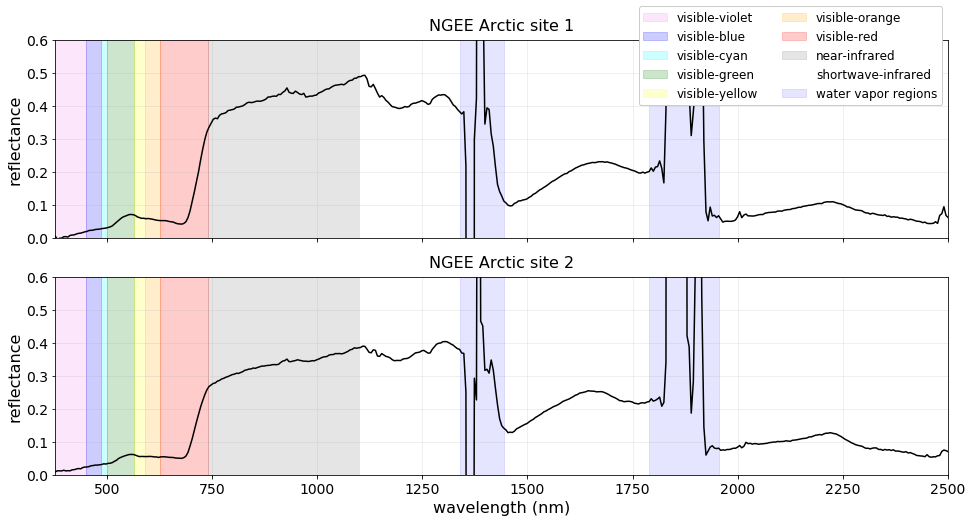

In [12]:
%matplotlib inline
titlefont = {'fontsize':16,'fontweight':2,
             'verticalalignment':'baseline','horizontalalignment':'center'}
plt.rcParams['figure.figsize'] = [16, 8]

# plot. all of this is matplotlib ---------->
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex=ax1)

_bands.plot(x='Band center (nm)', y=site1name+" reflectance", 
            ax=ax1, c='black', label='_nolegend_', legend=False)
_bands.plot(x='Band center (nm)', y=site2name+" reflectance", 
            ax=ax2, c='black', label='_nolegend_', legend=False)

for i, ax in enumerate([ax1,ax2]): 
    
    # add shaders for band regions
    for region,limits in band_dictionary.items():
        ax.axvspan(limits['lower'], limits['upper'], alpha=0.2, 
                   color=limits['color'], label=region)
        
    # add water vapor region shaders
    ax.axvspan(1340, 1445, alpha=0.1, color='blue', label='water vapor regions')
    ax.axvspan(1790, 1955, alpha=0.1, color='blue')
    
    # some plotting config
    ax.set_ylim(0,0.6)
    ax.set_xlim(min(band_centers),max(band_centers))
    ax.set_ylabel("reflectance", fontsize=16)
    ax.set_xlabel("wavelength (nm)", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid('on', alpha=0.25)
    ax.set_title("NGEE Arctic site "+str(i+1), fontdict = titlefont, pad = 10)

# now add custom legend
ax1.legend(prop={'size': 12}, loc = 'upper right', 
           bbox_to_anchor=(1, 1.2), ncol = 2, framealpha = 1)

## 3. Plot individual bands and multiband composites  <a name="plotbands"></a>

### Plot RGB bands  <a name="plotrgbbands"></a>
You access bands of the raster using `img.GetRasterBand(<int>)`. Extract the R, G, and B bands and prep to plot in three steps:            
    
    a. determine bands nearest the center of red, green, blue regions of EM spectrum      
    b. get the bands and scale reflectance values to 8-bits       
    c. stack the bands   

In [13]:
# a ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# function finds band in our table with wavelength nearest to input r,g,b wavelengths
get_band_number = lambda w: bands.iloc[(bands["Band center (nm)"]-w).abs().argsort()[1]]

# get band numbers. use R: 667.5nm, G: 540nm, B: 470nm
Ri, Gi, Bi = get_band_number(667.5), get_band_number(540), get_band_number(470)

# print band information from the table
print(str("\n"+"---"*20+"\n").join([str(Ri),str(Gi),str(Bi)]))

# b ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# function gets numpy array from input band
get_band = lambda b: img.GetRasterBand(int(b["Band number"])).ReadAsArray()

# get r,g,b arrays
Ra, Ga, Ba = get_band(Ri), get_band(Gi), get_band(Bi)

# set fill values (-9999.) to 0 for each array
Ra[Ra == -9999.], Ga[Ga == -9999.], Ba[Ba == -9999.] = 0, 0, 0

# function scales reflectance values to 8bits
scale8bit = lambda a: ((a - a.min()) * (1/(a.max() - a.min()) * 255)).astype('uint8')

# get 8bit arrays for each band
Ra8, Ga8, Ba8 = scale8bit(Ra), scale8bit(Ga), scale8bit(Ba)

# set rescaled fill pixels back to 0 for each array
Ra8[Ra == 0], Ga8[Ga == 0], Ba8[Ba == 0] = 0, 0, 0

# c ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# make rgb stack
rgb_stack = np.zeros((nrows,ncols,3),'uint8')
rgb_stack[...,0], rgb_stack[...,1], rgb_stack[...,2] = Ra8, Ga8, Ba8

# print shape of raster stack
print("---"*20+"\nRGB stack (rows,cols,bands): " + str(rgb_stack.shape))

Band number                     59
Band center (nm)            667.36
EM region              visible-red
TL_IS_2 reflectance      0.0421733
TL_IS_3 reflectance      0.0506357
Name: 59, dtype: object
------------------------------------------------------------
Band number                       34
Band center (nm)              542.15
EM region              visible-green
TL_IS_2 reflectance        0.0647069
TL_IS_3 reflectance        0.0576541
Name: 34, dtype: object
------------------------------------------------------------
Band number                      20
Band center (nm)             472.02
EM region              visible-blue
TL_IS_2 reflectance       0.0245943
TL_IS_3 reflectance       0.0295215
Name: 20, dtype: object
------------------------------------------------------------
RGB stack (rows,cols,bands): (4207, 637, 3)


Get the raster geotransform and generate arrays of coordinates to labels the x and y axes. The GDAL-style geotransform is described in six values: 
1. x minimum
2. x resolution 
3. x angle of rotation coefficient
4. y maximum
5. x angle of rotation coefficient
6. y resolution

We can construct the arrays using pieces one, two, four, and five:

In [14]:
# get the raster geotransform as its component parts
xmin, xres, xrot, ymax, yrot, yres = img.GetGeoTransform()

# generate coordinate arrays
xarr = np.array([int(xmin+i*xres) for i in range(0,ncols)])
yarr = np.array([int(ymax+i*yres) for i in range(0,nrows)])

print("the first 10 x coordinates:")
xarr[:10]

the first 10 x coordinates:


array([447779, 447783, 447787, 447791, 447796, 447800, 447804, 447808,
       447812, 447816])

Plot the R,G,B bands and the RGB stack:

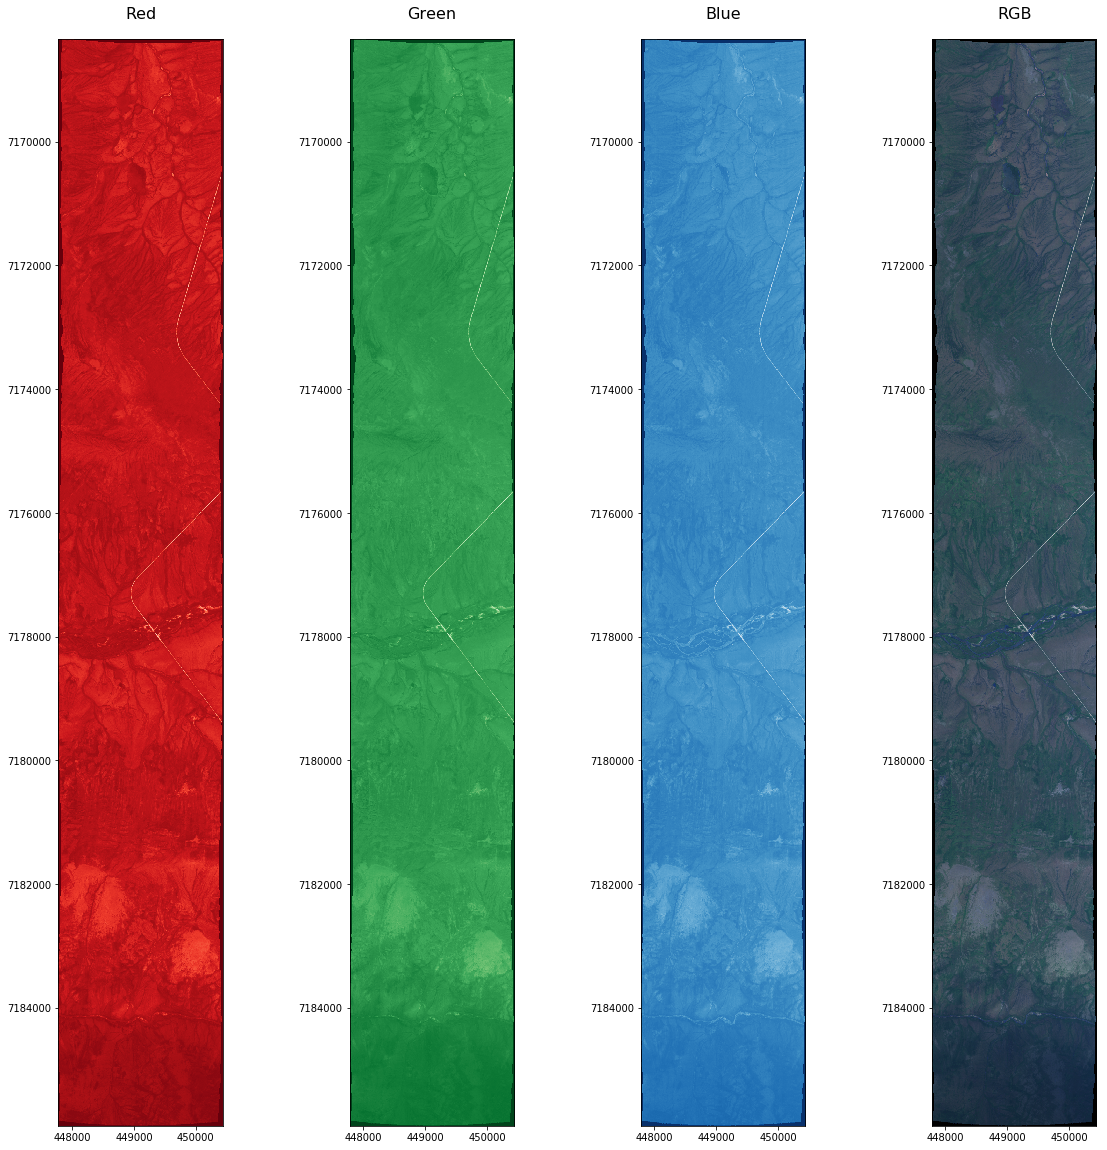

In [15]:
plt.rcParams['figure.figsize'] = [20, 20]
gs = gridspec.GridSpec(1, 4)

plotdict = { 'Red': { 'subplot': 0, 'array': Ra8, 'colormap': 'Reds_r' },
             'Green': { 'subplot': 1, 'array': Ga8, 'colormap': 'Greens_r' },
             'Blue': { 'subplot': 2, 'array': Ba8, 'colormap': 'Blues_r' },
             'RGB': { 'subplot': 3, 'array': rgb_stack, 'colormap': None } }

# initialize plot and add ax element for each array in plotdict
fig1 = plt.figure()
for band,data in plotdict.items():
    clim = None if band == "RGB" else (0,255)
    ax = fig1.add_subplot(gs[ 0, data['subplot'] ])
    p = ax.imshow(data['array'], cmap=data['colormap'], clim=clim,
                  extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])
    ax.set_title(band, pad = 20, fontdict = titlefont)  
    
plt.imshow(rgb_stack, extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])

### Equalize histograms  <a name="equalizehist"></a>

The RGB composite looks kind of washed out. Equalize histograms and plot again:

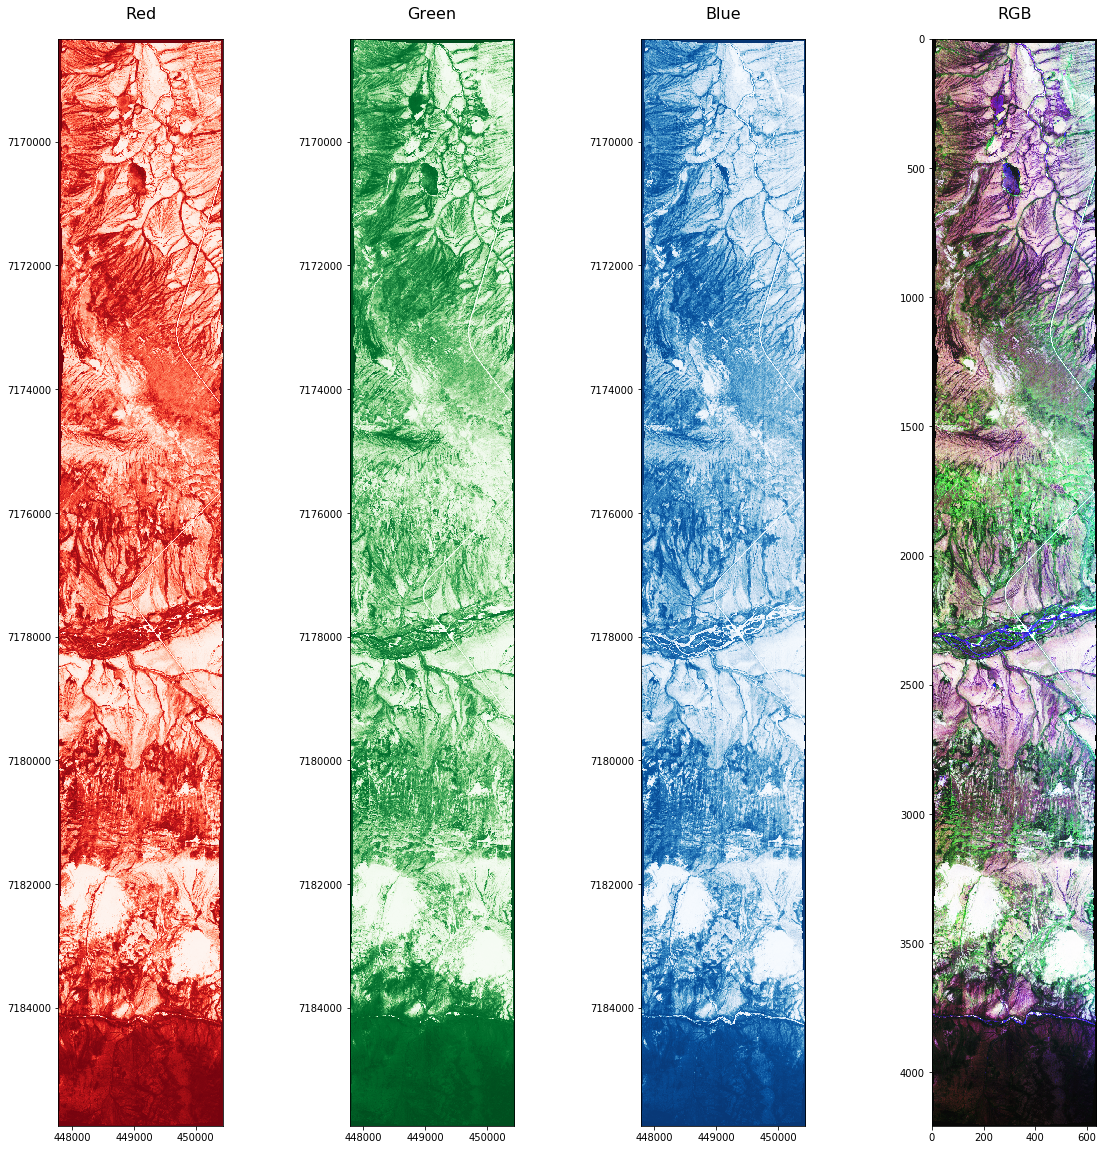

In [16]:
# apply histogram equalization to each band
for i in range(rgb_stack.shape[2]):

    # band i
    b = rgb_stack[:,:,i]
    
    # histogram from flattened (1d) image
    b_histogram, bins = np.histogram(b.flatten(), 256)

    # cumulative distribution function
    b_cumdistfunc = b_histogram.cumsum()

    # normalize
    b_cumdistfunc = 255 * b_cumdistfunc / b_cumdistfunc[-1]

    # get new values by linear interpolation of cdf
    b_equalized = np.interp(b.flatten(), bins[:-1], b_cumdistfunc)
    
    # reshape to 2d and add back to rgb_stack
    rgb_stack[:,:,i] = b_equalized.reshape(b.shape)
    
    
# plot. all of this is matplotlib ---------->
plt.rcParams['figure.figsize'] = [20, 20]
gs = gridspec.GridSpec(1, 4)

plotdict = { 'Red': { 'subplot': 0, 'array': rgb_stack[:,:,0], 'colormap': 'Reds_r' },
             'Green': { 'subplot': 1, 'array': rgb_stack[:,:,1], 'colormap': 'Greens_r' },
             'Blue': { 'subplot': 2, 'array': rgb_stack[:,:,2], 'colormap': 'Blues_r' },
             'RGB': { 'subplot': 3, 'array': rgb_stack, 'colormap': None } }

# initialize plot and add ax element for each array in plotdict
fig1 = plt.figure()
for band,data in plotdict.items():
    clim = None if band == "RGB" else (0,255)
    ax = fig1.add_subplot(gs[ 0, data['subplot'] ])
    p = ax.imshow(data['array'], cmap=data['colormap'], clim=clim,
                  extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])
    ax.set_title(band, pad = 20, fontdict = titlefont)
plt.imshow(rgb_stack)

## 4. Calculate vegetation indices  <a name="calculatevis"></a>

### NDVI  <a name="ndvi"></a>

**Normalized Difference Vegetation Index (NDVI)** is a simple metric used to get a general sense of the quantity and condition of the vegetation on the earth's surface. NDVI takes advantage of the strong difference in reflectivity of vegetation in the red and near-infrared ranges.      

The pigment in plant leaves, chlorophyll, strongly absorbs visible light (from 400 to 700 nm) for use in photosynthesis. The cell structure of the leaves, on the other hand, strongly reflects near-infrared light (from 700 nm to 1100 nm). The more leaves a plant has, the more these wavelengths of light are affected, respectively.       

NDVI is traditionally calculated as follows:
```
NDVI = (R900-R685)/(R900+R685)
```
Select the bands nearest to recommended NDVI bands 685 nm (red) and 900 nm (near-infrared), calculate NDVI using the formula above, and print some statistics (we'll plot the result in the next step) :

In [17]:
# find bands nearest to NDVI red and nir wavelengths
ndvi_red, ndvi_nir = get_band_number(685), get_band_number(900)

# print band information from the table
print(str("\n"+"---"*20+"\n").join([str(ndvi_red),str(ndvi_nir)]))

# get the numpy arrays for the two bands
R685, R900 = get_band(ndvi_red), get_band(ndvi_nir)

# set fill value to numpy nan for all -9999.
R685[R685 == -9999.], R900[R900 == -9999.] = np.nan, np.nan

# calculate ndvi
ndvi_array = (R900-R685)/(R900+R685)

# print ndvi statistics
print(str("---"*20+"\n")+", ".join([
    "NDVI stats --- mean: "+str(np.nanmean(ndvi_array)), 
    "std: "+str(np.nanstd(ndvi_array)), 
    "min: "+str(np.nanmin(ndvi_array)), 
    "max: "+str(np.nanmax(ndvi_array)) 
]))

Band number                     63
Band center (nm)             687.4
EM region              visible-red
TL_IS_2 reflectance      0.0479951
TL_IS_3 reflectance      0.0565209
Name: 63, dtype: object
------------------------------------------------------------
Band number                      105
Band center (nm)              897.76
EM region              near-infrared
TL_IS_2 reflectance         0.429543
TL_IS_3 reflectance         0.334656
Name: 105, dtype: object
------------------------------------------------------------
NDVI stats --- mean: 0.6751264, std: 0.12133021, min: -1.4686599, max: 0.99976563


### More broadband VIs   <a name="broadbandvis"></a>

**Simple Ratio (SR; Birth and McVey 1968)**       
* the ratio of (1) the wavelength with highest reflectance for vegetation and (2) the wavelength of the deepest chlorophyll absorption. The simple equation is easy to understand and is effective over a wide range of conditions. As with the NDVI, it can saturate in dense vegetation when LAI becomes very high.   
* values range ~1-30
* Birth, G., and G. McVey. "Measuring the Color of Growing Turf with a Reflectance Spectrophotometer." Agronomy Journal 60 (1968): 640-643. https://doi.org/10.2134/agronj1968.00021962006000060016x       
```
SR = R750/R705
```

**Soil Adjusted Vegetation Index (SAVI; Huete 1988)**       
* similar to NDVI, but it suppresses the effects of soil pixels. It uses a canopy background adjustment factor, L, which is a function of vegetation density and often requires prior knowledge of vegetation amounts      
* Huete, A. "A Soil-Adjusted Vegetation Index (SAVI)." Remote Sensing of Environment 25 (1988): 295-309. https://doi.org/10.1016/0034-4257(88)90106-X     

```
SAVI = L*(R900-R685)/(R900+R685+L); where L is a canopy background adjustment factor   
```
"L value of 0.5 in reflectance space was found to minimize soil brightness variations and eliminate the need for additional calibration for different soils. The transformation was found to nearly eliminate soil-induced variations in vegetation indices" (Huete et al. 1988)

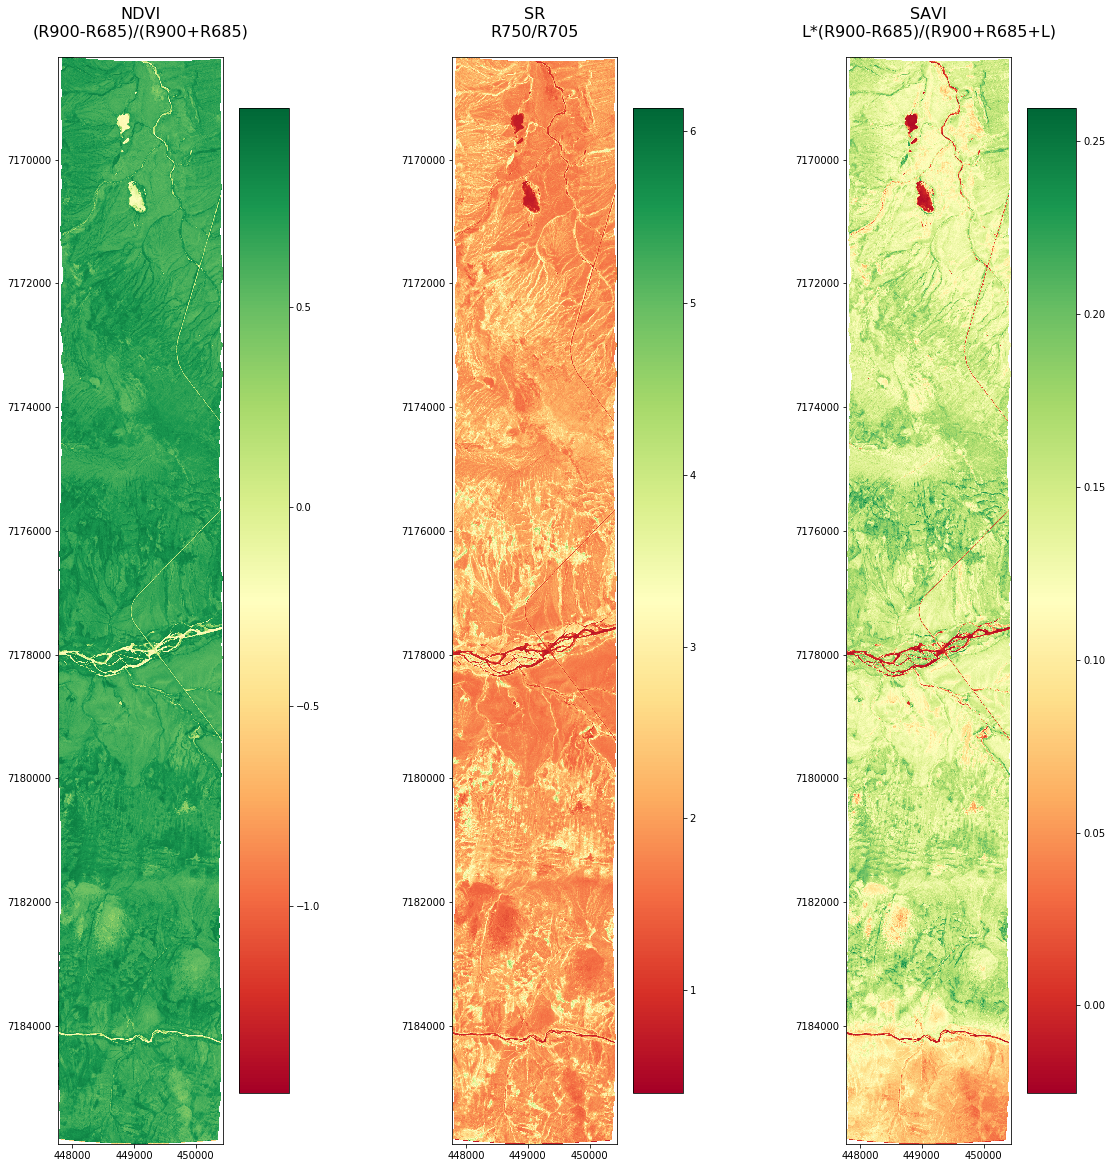

In [18]:
# get sr bands
R750, R705 = get_band(get_band_number(750)), get_band(get_band_number(705))
# set fill value to numpy nan for all -9999.
R705[R705 == -9999.], R750[R750 == -9999.] = np.nan, np.nan
# calculate sr
sr_array = R750/R705

# calculate savi
savi_array = 0.5*(R900-R685)/(R900+R685+0.5)

# plot. all of this is matplotlib ---------->
gs = gridspec.GridSpec(1, 3)

plotdict1 = { 'NDVI\n(R900-R685)/(R900+R685)': { 'subplot': 0, 'array': ndvi_array },
             'SR\nR750/R705': { 'subplot': 1, 'array': sr_array },
             'SAVI\nL*(R900-R685)/(R900+R685+L)': { 'subplot': 2, 'array': savi_array } }

# initialize plot and add ax element for each array in plotdict
fig2 = plt.figure()
for band,data in plotdict1.items():
    ax = fig2.add_subplot(gs[ 0, data['subplot'] ])
    p = ax.imshow(data['array'], cmap=plt.get_cmap("RdYlGn"),
                  extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])
    ax.set_title(band, pad = 20, fontdict = titlefont)
    plt.colorbar(p)

## 5. Save outputs; Common raster operations <a name="rastersaving"></a>

### Save the SAVI array to GeoTIFF <a name="savesavi"></a>

Now save the SAVI array to a GeoTIFF named `savi.tif`. Using GDAL, create an output raster dataset and then write the SAVI array to band 1:

In [19]:
# open gdal raster dataset for writing
outraster1 = gdal.GetDriverByName('GTiff').Create(
    "savi.tif",                                     # output GeoTIFF
    img.RasterXSize,                                # number of columns
    img.RasterYSize,                                # number of rows
    1 ,                                             # number of bands
    gdal.GDT_Float32)                               # data type

# set geotransform and projection information
geo = img.GetGeoTransform()                         # get geotransform from input raster
outraster1.SetGeoTransform(geo)                     # set geotransform
wkt = img.GetProjection()                           # get projection from input raster
outraster1.SetProjection(wkt)                       # set projection 

# get band 1
outraster1b = outraster1.GetRasterBand(1)           # get band 1 of output

# write to band 1
savi_array[np.isnan(savi_array)] = -9999.           # fill np.nan in savi array with -9999.0
outraster1b.WriteArray(savi_array)                  # write savi array to band 1;
outraster1b.SetNoDataValue(-9999)                   # set nodata value to -9999

outraster1.FlushCache()                             # write out
outraster1 = None                                   # close the file

### Subset the raster using a watershed boundary provided by NGEE Arctic <a name="subsetsavi"></a>

Now use GDAL warp's cutline arguments to crop and mask the SAVI raster using a watershed boundary shapefile. Teller watershed contains the NGEE Arctic sites that we plotted earlier in the tutorial:          
[ngee-data/Teller_Watershed/Watershed_NGEE_Arctic_Seward_Peninsula_Teller_20171211.shp](ngee-data/Teller_Watershed/Watershed_NGEE_Arctic_Seward_Peninsula_Teller_20171211.shp)   

Save the cropped and masked raster as `savi_clipped.tif`:

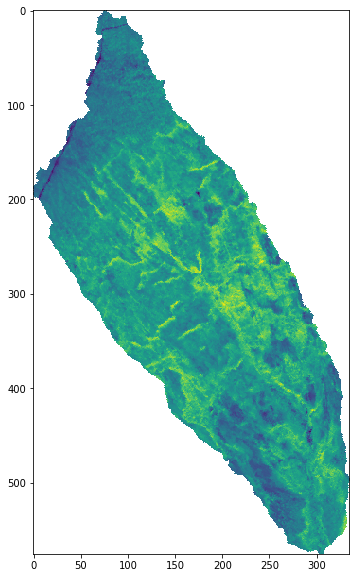

In [20]:
watershed="ngee-data/Teller_Watershed/Watershed_NGEE_Arctic_Seward_Peninsula_Teller_20171211.shp"
shp = ogr.Open(watershed)                                  # open shapefile
lyr = shp.GetLayer()                                       # get first (and only) layer

outraster2 = gdal.Warp(
    "savi_clipped.tif",                                    # output GeoTIFF
    "savi.tif",                                            # input GeoTIFF
    format = 'GTiff',                                      # output format
    cutlineDSName = watershed,                             # input masking/clipping shapefile
    cutlineLayer = lyr.GetName(),                          # name of masking/clipping layer
    cropToCutline = True,                                  # reduce to nodata inner ext
    dstNodata = -9999)                                     # output raster nodata value 

# plot it
plt.rcParams['figure.figsize'] = [10, 10]                  # set dimensions of rendered plot
clipped_savi = outraster2.GetRasterBand(1).ReadAsArray()   # get array from the output raster
clipped_savi[clipped_savi == -9999.] = np.nan              # set -9999. back to numpy nan
plt.imshow(clipped_savi)                                   # plot with matplotlib's imshow

### Warp to WGS84 and save to GeoTIFF <a name="warpsavi"></a>

Use GDAL warp again to save a GeoTIFF in WGS84 as `savi_clipped_wgs84.tif`:

In [21]:
outsrs = osr.SpatialReference()                             # init osr srs object
outsrs.ImportFromEPSG(4326)                                 # import WGS84 srs definitions

# create virtual warped raster
warp = gdal.AutoCreateWarpedVRT(
    outraster2,                                             # source raster 
    wkt,                                                    # source raster well-known text
    outsrs.ExportToWkt())                                   # output raster well-known text
warpb = warp.GetRasterBand(1).ReadAsArray()                 # warped raster band

# create output raster dataset; write warped raster array
outraster3 = gdal.GetDriverByName('GTiff').Create(
    'savi_clipped_wgs84.tif',                               # name of output tif
    warp.RasterXSize,                                       # warped raster ncols
    warp.RasterYSize,                                       # warped raster nrows
    1,                                                      # warped raster nbands
    gdal.GDT_Float32)                                       # data type

outraster3.SetGeoTransform(warp.GetGeoTransform())          # set output geotransform
outraster3.SetProjection(warp.GetProjection())              # set output projection
outraster3b = outraster3.GetRasterBand(1)                   # get band 1
outraster3b.WriteArray(warpb)                               # add band values
outraster3b.SetNoDataValue(-9999)                           # set output nodata
outraster3.FlushCache()                                     # write output

# close all open files
img = None
outraster2 = None
outraster3 = None
warp = None